# Toronto anomalies analysis
Anomalies detection and performance measurement

### Importing necessary libraries

In [213]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import utils
import os.path
from __future__ import division
from sklearn import preprocessing
import matplotlib.dates as mdates
import statsmodels.api as sm
import seaborn as sns
from sklearn.metrics import f1_score
sns.set_style('whitegrid')
sns.set_context('talk')
import statistics

### Loading the data

In [29]:
SITE = 7881
channels = pd.read_csv('../dataset/channels.csv')
channels[channels.siteId == SITE].head()

,siteId,channelId,channelName,units,isCalculated
81478,7881,14656,V Raw Average,m/s,False
81479,7881,14033,Raw Average Velocity,m/s,False
81480,7881,11738,MP1 PDEPTH_1,mm,False
81481,7881,11745,MP1 VFINAL,m/s,False
81482,7881,19698,MP1 VInterim,m/s,False


### Assigning the channelId value to variable

In [30]:
raw = 11742
final = 11744

### Using utils to load the values from chosen channels

In [31]:
raw = utils.load_channel_data(SITE, raw).rename('raw').fillna(0)
final = utils.load_channel_data(SITE, final).rename('final').fillna(0)

### Short description of the data

In [32]:
raw.describe()

count    334081.000000
mean        220.228096
std          99.490495
min        -253.750000
25%         212.250000
50%         251.360001
75%         268.940002
max         714.309998
Name: raw, dtype: float64

In [33]:
final.describe()

count    285241.000000
mean        248.445642
std          32.769104
min         118.669998
25%         229.869995
50%         253.250000
75%         269.390015
max         622.309998
Name: final, dtype: float64

### Creating data frame on all data

In [102]:
all_data = pd.concat([raw,final],axis=1)
all_data['diff'] = np.abs(df.raw - df.final)

In [103]:
all_data.describe()

,raw,final,diff
count,334081.000000,285241.000000,284093.000000
mean,220.228096,248.445642,15.119353
std,99.490495,32.769104,53.732429
min,-253.750000,118.669998,0.000000
25%,212.250000,229.869995,0.000000
50%,251.360001,253.250000,0.000000
75%,268.940002,269.390015,0.000000
max,714.309998,622.309998,454.829987


In [45]:
all_data = all_data.reset_index()

### Showing the general plot of all data

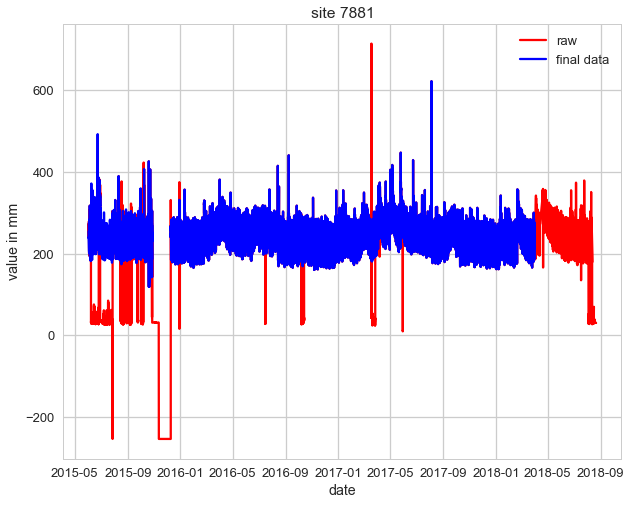

In [47]:
plt.figure(figsize=(10, 8))

plt.plot(all_data['time'].values.reshape(-1,1), all_data['raw'], color="red",
    label="raw")
plt.plot(all_data['time'].values.reshape(-1,1), all_data['final'], c='blue', label="final data")
plt.xlabel("date")
plt.ylabel("value in mm")
plt.title("site 7881")
plt.legend()
plt.show()

### Adding the difference between raw and final

In [104]:
df = pd.concat([raw, final], axis=1).dropna()
df['diff'] = np.abs(df.raw - df.final)
print('Anomalies in raw: {:}'.format(len(df[df['diff'] > 1])))

Anomalies in raw: 31150


### Creating anomalies data frame

In [105]:
anomalies = df[df['diff'] > 1]
anomalies = anomalies.reset_index()
anomalies[['raw','final','diff']].head()

,raw,final,diff
0,259.720001,275.579987,15.859985
1,253.669998,263.100006,9.430008
2,258.690002,262.519989,3.829987
3,256.290009,260.390015,4.100006
4,253.600006,259.440002,5.839996


### Short description of the anomalies data frame

In [106]:
anomalies.describe()

,raw,final,diff
count,31150.000000,31150.000000,31150.000000
mean,107.372836,241.775380,137.871722
std,103.313789,28.616929,96.994310
min,9.660000,168.910004,1.009995
25%,30.440001,221.872498,9.319996
50%,38.000000,247.149994,183.534998
75%,232.825001,259.989990,217.619995
max,714.309998,492.570007,454.829987


### Implementing and testing F1 score metric on naive model which predicted 0 anomalies

In [167]:
print('Anomalies in raw: {:}'.format(len(all_data[all_data['diff'] > 1])))

Anomalies in raw: 31150


In [168]:
all_data['if_anomaly'] = 0
all_data['if_anomaly'] = (all_data['diff']).map(lambda x: 1 if x>1 else 0)

In [169]:
all_data['naive_model'] = 0

In [170]:
all_data = all_data.dropna()

In [171]:
all_data.describe()

,raw,final,diff,if_anomaly,naive_model
count,284093.000000,284093.000000,284093.000000,284093.000000,284093.0
mean,233.715441,248.452225,15.119353,0.109647,0.0
std,64.159360,32.796490,53.732429,0.312450,0.0
min,9.660000,118.669998,0.000000,0.000000,0.0
25%,218.360001,229.860001,0.000000,0.000000,0.0
50%,251.929993,253.259995,0.000000,0.000000,0.0
75%,269.070007,269.420013,0.000000,0.000000,0.0
max,714.309998,622.309998,454.829987,1.000000,0.0


### Implementing F1 score manually

In [172]:
def F1(precision, recall):
    score = 2 * (precision * recall) / (precision + recall)
    return score

In [173]:
#TruePositive = Number of positives that are correctly predicted
#FalsePositive = Number of predicted positives that are incorrect

def precision(TruePositive, FalsePositive):
    prec = TruePositive/(TruePositive+FalsePositive)
    return prec

In [174]:
#TruePositive = Number of positives that are correctly predicted
#FalseNegative = Number of negatives that are incorrectly classified

def recall(TruePositive, FalseNegative):
    rec = TruePositive/(TruePositive+FalseNegative)
    return rec

In [175]:
TruePositive = (284093 - 31150)
FalsePositive = 31150
FalseNegative = 0

In [176]:
precision(TruePositive,FalsePositive)

0.8903528070033404

In [177]:
recall(TruePositive,FalseNegative)

1.0

In [178]:
F1(0.8903528070033404,1.0)

0.9419964397172629

### Implementing F1 score with the existing library

In [181]:
y_true = all_data['if_anomaly']
y_pred = all_data['naive_model']

In [231]:
f1_score(y_true, y_pred, average=None)

/home/alicja/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([0.94199644, 0.        ])

In [232]:
f1_score(y_true, y_pred, average='micro')

0.8903528070033404

### Boxlplot on raw data

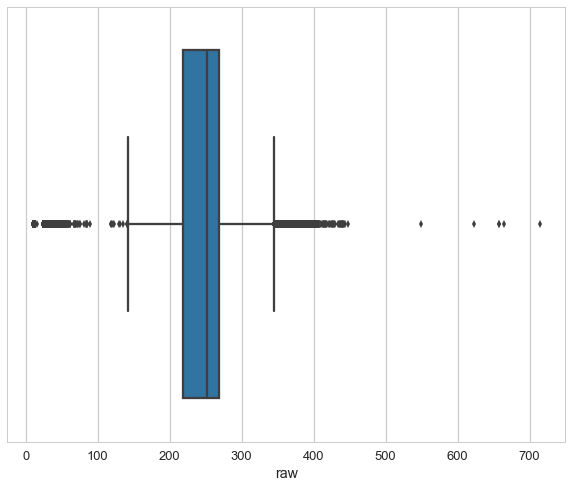

In [235]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.boxplot(x=all_data['raw'])

### Standard deviation for outliers detection

In [211]:
statistics.stdev(all_data['raw'])

64.15936012489973

In [212]:
statistics.mean(all_data['raw'])

233.71544060768508

In [216]:
up_limit = 233.71544060768508 + (2 * 64.15936012489973)
down_limit = 233.71544060768508 - (2 * 64.15936012489973)

In [221]:
all_data['std_anomaly'] = 0

In [223]:
all_data['std_anomaly'] = (all_data['raw']).map(lambda x: 1 if x> up_limit or x<down_limit else 0)

In [225]:
y_true2 = all_data['if_anomaly']
y_pred2 = all_data['std_anomaly']

In [227]:
f1_score(y_true2, y_pred2, average='micro')

0.9601609332155315